# 数据分析咖哥十话

## 第4话 百川争流终归海：动态归因优化渠道

**题解** 归因分析（attribution analysis）要解决的问题就是评估各个渠道的推广效果，合理地把功劳分配给给转化路径中的接触点，也就是各个渠道。运营人员会选择归因模型来衡量ROI，并根据归因结果优化营销资源。。

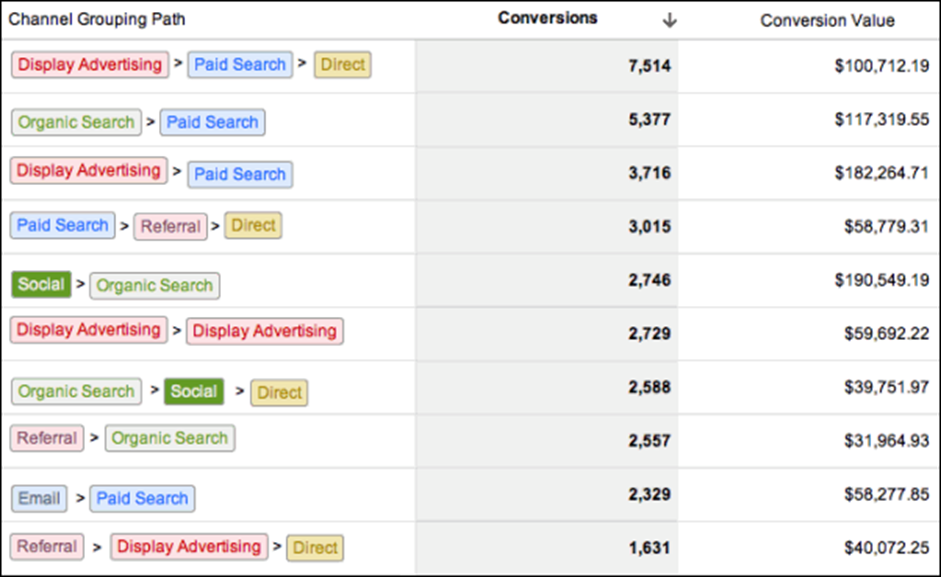

<center>渠道和渠道转化</center>

**详细内容请参考拙作：《数据分析咖哥十话》** 人民邮电出版社2022年出版
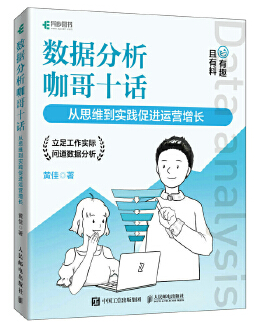
购书链接：https://item.jd.com/13335199.html

In [1]:
import numpy as np # 导入NumPy
import pandas as pd # 导入Pandas
df_data = pd.read_csv('渠道转化.csv') # 载入数据
df_data # 输出数据

,用户cookie,时戳,是否转化,转化值,渠道
0,6AC99iBniiDifh3n3nnBo03AB,2021-07-03T11:37:54Z,0,0.0,付费搜索
1,6AC99iBniiDifh3n3nnBo03AB,2021-07-03T13:42:48Z,0,0.0,快手
2,6AC99iBniiDifh3n3nnBo03AB,2021-07-04T12:25:55Z,0,0.0,快手
3,6AC99iBniiDifh3n3nnBo03AB,2021-07-05T07:27:28Z,0,0.0,抖音
4,6AC99iBniiDifh3n3nnBo03AB,2021-07-10T07:34:49Z,0,0.0,抖音
...,...,...,...,...,...
7627,8el7kAnk73kFFDFkf77k9EiAB,2021-07-24T07:19:29Z,0,0.0,付费搜索
7628,8el90C3hDA0DE37h3Bok3FoAn,2021-07-17T11:32:14Z,0,0.0,付费搜索
7629,8el90C3hDA0DE37h3Bok3FoAn,2021-07-17T11:33:16Z,0,0.0,付费搜索
7630,8el97kofnAFk7hno9i0ki0hof,2021-07-15T13:00:40Z,0,0.0,付费搜索


In [2]:
df_data = df_data.sort_values(['用户cookie', '时戳'], ascending=[False, True]) # 按用户cookie 进行时戳排序
df_data # 输出数据

,用户cookie,时戳,是否转化,转化值,渠道
7608,8eloi73CoEE3037h7kF7ohCik,2021-07-12T10:45:30Z,0,0.0,抖音
7607,8elo9hE3oBhD7DBD9finCDfni,2021-07-30T11:13:43Z,0,0.0,付费搜索
7606,8elnn97fCiBEE9DiiE7nfh7Bh,2021-07-12T17:20:44Z,0,0.0,B站
7601,8elnh90F30hnoACDkB0oE9kiE,2021-07-28T12:04:16Z,0,0.0,付费搜索
7602,8elnh90F30hnoACDkB0oE9kiE,2021-07-28T12:04:51Z,0,0.0,付费搜索
...,...,...,...,...,...
2214,6AC0iACDFBEAfE7B0ikBBoEAB,2021-07-16T18:37:46Z,0,0.0,快手
2215,6AC0iACDFBEAfE7B0ikBBoEAB,2021-07-19T19:33:18Z,0,0.0,快手
2209,6AC0F0nA3ADAn9D07nFFihC90,2021-07-05T21:35:17Z,0,0.0,B站
2210,6AC0F0nA3ADAn9D07nFFihC90,2021-07-21T17:16:59Z,0,0.0,小红书


In [3]:
df_data['访问次序'] = df_data.groupby('用户cookie').cumcount() + 1 # 增加一个“访问次序”字段
df_data # 输出数据

,用户cookie,时戳,是否转化,转化值,渠道,访问次序
7608,8eloi73CoEE3037h7kF7ohCik,2021-07-12T10:45:30Z,0,0.0,抖音,1
7607,8elo9hE3oBhD7DBD9finCDfni,2021-07-30T11:13:43Z,0,0.0,付费搜索,1
7606,8elnn97fCiBEE9DiiE7nfh7Bh,2021-07-12T17:20:44Z,0,0.0,B站,1
7601,8elnh90F30hnoACDkB0oE9kiE,2021-07-28T12:04:16Z,0,0.0,付费搜索,1
7602,8elnh90F30hnoACDkB0oE9kiE,2021-07-28T12:04:51Z,0,0.0,付费搜索,2
...,...,...,...,...,...,...
2214,6AC0iACDFBEAfE7B0ikBBoEAB,2021-07-16T18:37:46Z,0,0.0,快手,4
2215,6AC0iACDFBEAfE7B0ikBBoEAB,2021-07-19T19:33:18Z,0,0.0,快手,5
2209,6AC0F0nA3ADAn9D07nFFihC90,2021-07-05T21:35:17Z,0,0.0,B站,1
2210,6AC0F0nA3ADAn9D07nFFihC90,2021-07-21T17:16:59Z,0,0.0,小红书,2


In [4]:
df_paths = df_data.groupby('用户cookie')['渠道'].aggregate( # 根据用户cookie 构建路径（各渠道间的用户旅程）
    lambda x: x.unique().tolist()).reset_index() #lambda 后面是匿名函数
df_last_step = df_data.drop_duplicates('用户cookie', keep='last')[['用户cookie', '是否转化']] # 保留用户最后的一条记录（确定是否转化）
df_paths = pd.merge(df_paths, df_last_step, how='left', on='用户cookie') # 合并路径信息和用户是否转化的信息
df_paths # 输出数据

,用户cookie,渠道,是否转化
0,6AC09oon9oB0C03AioB37kA0f,[B站],0
1,6AC0F0nA3ADAn9D07nFFihC90,"[B站, 小红书]",0
2,6AC0iACDFBEAfE7B0ikBBoEAB,"[快手, B站]",0
3,6AC0kDDAABF3FB0iAF0hfoC3n,[B站],0
4,6AC0ko970f3Fho9AnDioDo399,[付费搜索],0
...,...,...,...
3114,8elnEnfAEoFiAiiCioAnhFBf9,[B站],0
3115,8elnh90F30hnoACDkB0oE9kiE,[付费搜索],0
3116,8elnn97fCiBEE9DiiE7nfh7Bh,[B站],0
3117,8elo9hE3oBhD7DBD9finCDfni,[付费搜索],0


In [5]:
df_paths['路径'] = np.where( df_paths['是否转化'] == 0, # 添加开始和转化结果
['开始, '] + df_paths['渠道'].apply(', '.join) + [', 未转化'], # 未购买游戏
['开始, '] + df_paths['渠道'].apply(', '.join) + [', 成功转化']) # 购买游戏
df_paths['路径'] = df_paths['路径'].str.split(', ') # 分割字符串，重新生成字符串列表
df_paths = df_paths[['用户cookie', '路径']] # 删除除“用户cookie”和“路径”之外的其他字段
df_paths # 输出数据

,用户cookie,路径
0,6AC09oon9oB0C03AioB37kA0f,"[开始, B站, 未转化]"
1,6AC0F0nA3ADAn9D07nFFihC90,"[开始, B站, 小红书, 未转化]"
2,6AC0iACDFBEAfE7B0ikBBoEAB,"[开始, 快手, B站, 未转化]"
3,6AC0kDDAABF3FB0iAF0hfoC3n,"[开始, B站, 未转化]"
4,6AC0ko970f3Fho9AnDioDo399,"[开始, 付费搜索, 未转化]"
...,...,...
3114,8elnEnfAEoFiAiiCioAnhFBf9,"[开始, B站, 未转化]"
3115,8elnh90F30hnoACDkB0oE9kiE,"[开始, 付费搜索, 未转化]"
3116,8elnn97fCiBEE9DiiE7nfh7Bh,"[开始, B站, 未转化]"
3117,8elo9hE3oBhD7DBD9finCDfni,"[开始, 付费搜索, 未转化]"


In [6]:
path_list = df_paths['路径'] # 创建路径列表对象
path_list # 输出列表

0            [开始, B站, 未转化]
1       [开始, B站, 小红书, 未转化]
2        [开始, 快手, B站, 未转化]
3            [开始, B站, 未转化]
4          [开始, 付费搜索, 未转化]
               ...        
3114         [开始, B站, 未转化]
3115       [开始, 付费搜索, 未转化]
3116         [开始, B站, 未转化]
3117       [开始, 付费搜索, 未转化]
3118         [开始, 抖音, 未转化]
Name: 路径, Length: 3119, dtype: object

In [7]:
total_conversions = sum(path.count('成功转化') for path in df_paths['路径'].tolist()) # 整体转化数
conversion_rate = total_conversions / len(path_list) # 基准转化率
print('整体转化数：',total_conversions) # 输出整体转化数
print('基准转化率：',conversion_rate) # 输出基准转化率

整体转化数： 228
基准转化率： 0.07310035267714012


In [8]:
def transition_states(path_list): # 构建中间转换状态计数函数
    unique_channels = set(x for element in path_list for x in element) # 独立路径列表
    transition_states = {x + '>' + y: 0 for x in unique_channels for y in unique_channels} # 中间状态列表
    for possible_state in unique_channels: # 遍历所有独立路径
        if possible_state not in ['成功转化', '未转化']: # 最终转化步骤之前的所有状态
            for user_path in path_list: # 遍历路径列表
                if possible_state in user_path: # 如果可能状态在该路径中
                    indices = [i for i, s in enumerate(user_path) if possible_state in s] # 设定索引
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1 # 计数值加1
    return transition_states # 返回计数值

In [9]:
trans_states = transition_states(path_list) # 调用中间转换状态计数函数
trans_states # 输出数据

{'快手>快手': 0,
 '快手>B站': 40,
 '快手>付费搜索': 22,
 '快手>抖音': 17,
 '快手>未转化': 396,
 '快手>开始': 0,
 '快手>小红书': 12,
 '快手>成功转化': 33,
 'B站>快手': 29,
 'B站>B站': 0,
 'B站>付费搜索': 55,
 'B站>抖音': 182,
 'B站>未转化': 832,
 'B站>开始': 0,
 'B站>小红书': 40,
 'B站>成功转化': 57,
 '付费搜索>快手': 26,
 '付费搜索>B站': 75,
 '付费搜索>付费搜索': 0,
 '付费搜索>抖音': 33,
 '付费搜索>未转化': 892,
 '付费搜索>开始': 0,
 '付费搜索>小红书': 60,
 '付费搜索>成功转化': 70,
 '抖音>快手': 12,
 '抖音>B站': 136,
 '抖音>付费搜索': 25,
 '抖音>抖音': 0,
 '抖音>未转化': 377,
 '抖音>开始': 0,
 '抖音>小红书': 13,
 '抖音>成功转化': 41,
 '未转化>快手': 0,
 '未转化>B站': 0,
 '未转化>付费搜索': 0,
 '未转化>抖音': 0,
 '未转化>未转化': 0,
 '未转化>开始': 0,
 '未转化>小红书': 0,
 '未转化>成功转化': 0,
 '开始>快手': 445,
 '开始>B站': 909,
 '开始>付费搜索': 1000,
 '开始>抖音': 352,
 '开始>未转化': 0,
 '开始>开始': 0,
 '开始>小红书': 413,
 '开始>成功转化': 0,
 '小红书>快手': 8,
 '小红书>B站': 35,
 '小红书>付费搜索': 54,
 '小红书>抖音': 20,
 '小红书>未转化': 394,
 '小红书>开始': 0,
 '小红书>小红书': 0,
 '小红书>成功转化': 27,
 '成功转化>快手': 0,
 '成功转化>B站': 0,
 '成功转化>付费搜索': 0,
 '成功转化>抖音': 0,
 '成功转化>未转化': 0,
 '成功转化>开始': 0,
 '成功转化>小红书': 0,
 '成功转化>成功转化': 0}

In [10]:
from collections import defaultdict # 导入defaultdict 模块
def transition_prob(path_list, trans_dict): # 构建计算状态间过渡概率的函数
    unique_channels = set(x for element in path_list for x in element) # 独立路径列表
    trans_prob = defaultdict(dict) # 过渡概率
    for state in unique_channels: # 遍历所有独立路径
        if state not in ['成功转化', '未转化']: # 最终转化步骤之前的所有状态
            counter = 0 # 初始化counter
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s] # 索引列表
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]] # 转化总计数值加1
                    for col in index:
                        if trans_dict[list(trans_dict)[col]] > 0:
                            state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter) # 计算过渡概率
                            trans_prob[list(trans_dict)[col]] = state_prob # 过渡概率结果
    return trans_prob # 返回过渡概率的列表

In [11]:
trans_prob = transition_prob(path_list, trans_states) # 调用计算状态间过渡概率的函数
trans_prob # 输出数据

defaultdict(dict,
            {'快手>B站': 0.07692307692307693,
             '快手>付费搜索': 0.04230769230769231,
             '快手>抖音': 0.032692307692307694,
             '快手>未转化': 0.7615384615384615,
             '快手>小红书': 0.023076923076923078,
             '快手>成功转化': 0.06346153846153846,
             'B站>快手': 0.024267782426778243,
             'B站>付费搜索': 0.04602510460251046,
             'B站>抖音': 0.15230125523012553,
             'B站>未转化': 0.6962343096234309,
             'B站>小红书': 0.03347280334728033,
             'B站>成功转化': 0.04769874476987448,
             '付费搜索>快手': 0.02249134948096886,
             '付费搜索>B站': 0.06487889273356401,
             '付费搜索>抖音': 0.028546712802768166,
             '付费搜索>未转化': 0.7716262975778547,
             '付费搜索>小红书': 0.05190311418685121,
             '付费搜索>成功转化': 0.06055363321799308,
             '抖音>快手': 0.019867549668874173,
             '抖音>B站': 0.2251655629139073,
             '抖音>付费搜索': 0.041390728476821195,
             '抖音>未转化': 0.6241721854304636,
    

In [12]:
def transition_matrix(path_list, transition_probabilities): # 构建过渡矩阵函数
    trans_matrix = pd.DataFrame() # 创建过渡矩阵对象
    unique_channels = set(x for element in path_list for x in element) # 独立渠道数
    for channel in unique_channels: # 遍历所有渠道
        trans_matrix[channel] = 0.00 # 初始化过渡矩阵对象
        trans_matrix.loc[channel] = 0.00 # 初始化过渡矩阵对象中的元素
        trans_matrix.loc[channel][channel] = 1.0 if channel in [' 成功转化', ' 未转化'] else 0.0 # 分别给元素赋默认值1 和0
    for key, value in transition_probabilities.items(): # 遍历所有可能的过渡状态
        origin, destination = key.split('>') # 用> 拆分元素
        trans_matrix.at[origin, destination] = value # 给元素赋值
    return trans_matrix # 返回过渡矩阵对象

trans_matrix = transition_matrix(path_list, trans_prob) # 调用过渡矩阵函数
trans_matrix # 输出数据

,快手,B站,付费搜索,抖音,未转化,开始,小红书,成功转化
快手,0.000000,0.076923,0.042308,0.032692,0.761538,0.0,0.023077,0.063462
B站,0.024268,0.000000,0.046025,0.152301,0.696234,0.0,0.033473,0.047699
付费搜索,0.022491,0.064879,0.000000,0.028547,0.771626,0.0,0.051903,0.060554
抖音,0.019868,0.225166,0.041391,0.000000,0.624172,0.0,0.021523,0.067881
未转化,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
开始,0.142674,0.291440,0.320616,0.112857,0.000000,0.0,0.132414,0.000000
小红书,0.014870,0.065056,0.100372,0.037175,0.732342,0.0,0.000000,0.050186
成功转化,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


<AxesSubplot:>

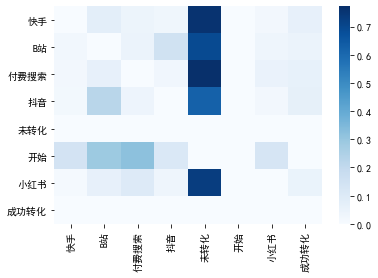

In [14]:
import matplotlib.pyplot as plt # 导入pyplot 模块
import seaborn as sns # 导入Seaborn
plt.rcParams["font.family"]=['SimHei'] #用来设定字体样式
plt.rcParams['font.sans-serif']=['SimHei'] #用来设定无衬线字体样式
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.heatmap(trans_matrix,cmap='Blues') # 输出相关性热力图

In [15]:
def removal_effects(df, conversion_rate): # 计算移除效应系数的函数
    removal_effects_dict = {} # 初始化集合
    channels = [channel for channel in df.columns if channel not in ['开始','未转化','成功转化']] # 渠道列表
    for channel in channels: # 遍历每一个渠道
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0) # 移除渠道
        for column in removal_df.columns: # 遍历每一列
            # 构建移除该渠道后的Dataframe 对象，即removal_df
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['未转化'] = null_pct
            removal_df.loc['未转化']['未转化'] = 1.0
        # 求移除该渠道之后的转化率
        removal_to_conv = removal_df[['未转化', '成功转化']].drop(['未转化', '成功转化'], axis=0)
        removal_to_non_conv = removal_df.drop(['未转化', '成功转化'],
        axis=1).drop(['未转化', '成功转化'], axis=0)
        removal_inv_diff = np.linalg.inv(np.identity(
        len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod, # 移除该渠道之后的转化率
        index=removal_to_conv.index)[[1]].loc['开始'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate # 求出该渠道的移除效应系数
        removal_effects_dict[channel] = removal_effect # 将结果赋给移除效应系数字典
    return removal_effects_dict # 返回移除效应系数字典

In [16]:
removal_effects_dict = removal_effects(trans_matrix, conversion_rate) # 调用计算移除效应系数的函数
removal_effects_dict # 输出数据

{'快手': 0.17312000754228052,
 'B站': 0.34439000213991866,
 '付费搜索': 0.36420723466102123,
 '抖音': 0.2273109609406747,
 '小红书': 0.15512576152392343}

<BarContainer object of 5 artists>

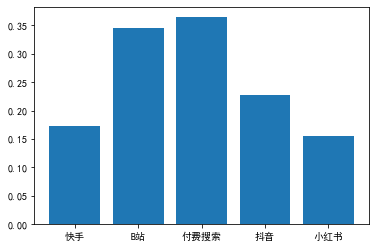

In [17]:
import matplotlib.pyplot as plt # 导入pyplot
plt.bar(removal_effects_dict.keys(),removal_effects_dict.values()) # 输出直方图

**就到这里！除马尔可夫链归因之外，还有另外一种常用的动态归因方法，就是求各个渠道的夏普利（Shapley）值。**

企业了解了每一个渠道的马尔可夫价值，就可以进行更好的资源分配，用同样的成本实现更优的整体转化率。
另外，企业根据相关矩阵和相关性热力图，能发现某些渠道之间有相辅相成的效果，组合起来转化率更高。对相关性强、过渡概率大的渠道组合，企业可以采取方法进一步加强渠道间的互动和协作。